In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import sys
sys.path.append('../../..')

from fridom.ShallowWater.ModelSettings import ModelSettings
from fridom.ShallowWater.Grid import Grid
from fridom.ShallowWater.State import State
from fridom.ShallowWater.Model import Model
from fridom.ShallowWater.Projection import GeostrophicSpectral
from fridom.ShallowWater.ModelPlotter import ModelPlotter

In [2]:
class FancyPlotter(ModelPlotter):
    def create_figure():
        fig = plt.figure(figsize=(15, 7.5), tight_layout=True)
        return fig
    
    def update_figure(fig, z, time, **kwargs):
        colors = ["black", "#09133e", "#1783aa", "#1affda" ]
        newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colors, N=256)
        plt.style.use(['dark_background'])
        norm = Normalize()

        X, Y = tuple(z.grid.X)
        u = z.u; v = z.v
        cs = (slice(0,None,25), slice(0,None,25))
        xf = X[cs].flatten(); yf = Y[cs].flatten()

        u_abs = (u**2 + v**2)**0.5
        fig.add_subplot(111)
        plt.pcolor(X, Y, u_abs, cmap=newcmp, vmin=0, vmax=1.0)

        uf = u[cs].flatten(); vf = v[cs].flatten()
        u_abs_f = u_abs[cs].flatten()
        norm.autoscale(u_abs_f)
        plt.quiver(xf, yf, uf, vf, scale=170, headwidth=6, color=plt.get_cmap("gist_gray")(norm(u_abs_f)))
        plt.xticks([])
        plt.yticks([])
        return

In [4]:
mset = ModelSettings(N=[2048, 1024], L=[2, 1])
mset.vid_anim_filename = 'fridom_new.mp4'
mset.vid_fps = 30
mset.vid_anim_interval = 300
mset.vid_plotter = FancyPlotter
mset.vid_max_jobs = 0.1
mset.Ro = 0.5
mset.dt = 0.00002

grid = Grid(mset)
z = State(mset, grid)
# load image
img = plt.imread('fridom.png')
mask = z.cp.array(1-img[::-1,:,0].T)
for _ in range(500):
    z.h[:] = mask*0.1
    z = GeostrophicSpectral(mset, grid)(z)

model = Model(mset, grid)
model.z = z.copy()
mset.dt *= -1
runlen = 1.5
model.run(runlen=-runlen)

# new model with plotting enabled
mset.enable_vid_anim = True
mset.dt *= -1
model2 = Model(mset, grid)
model2.z = model.z
model2.run(runlen=runlen)
model2.show_video()

100%|██████████| 75000/75000 [06:20<00:00, 197.03it/s]


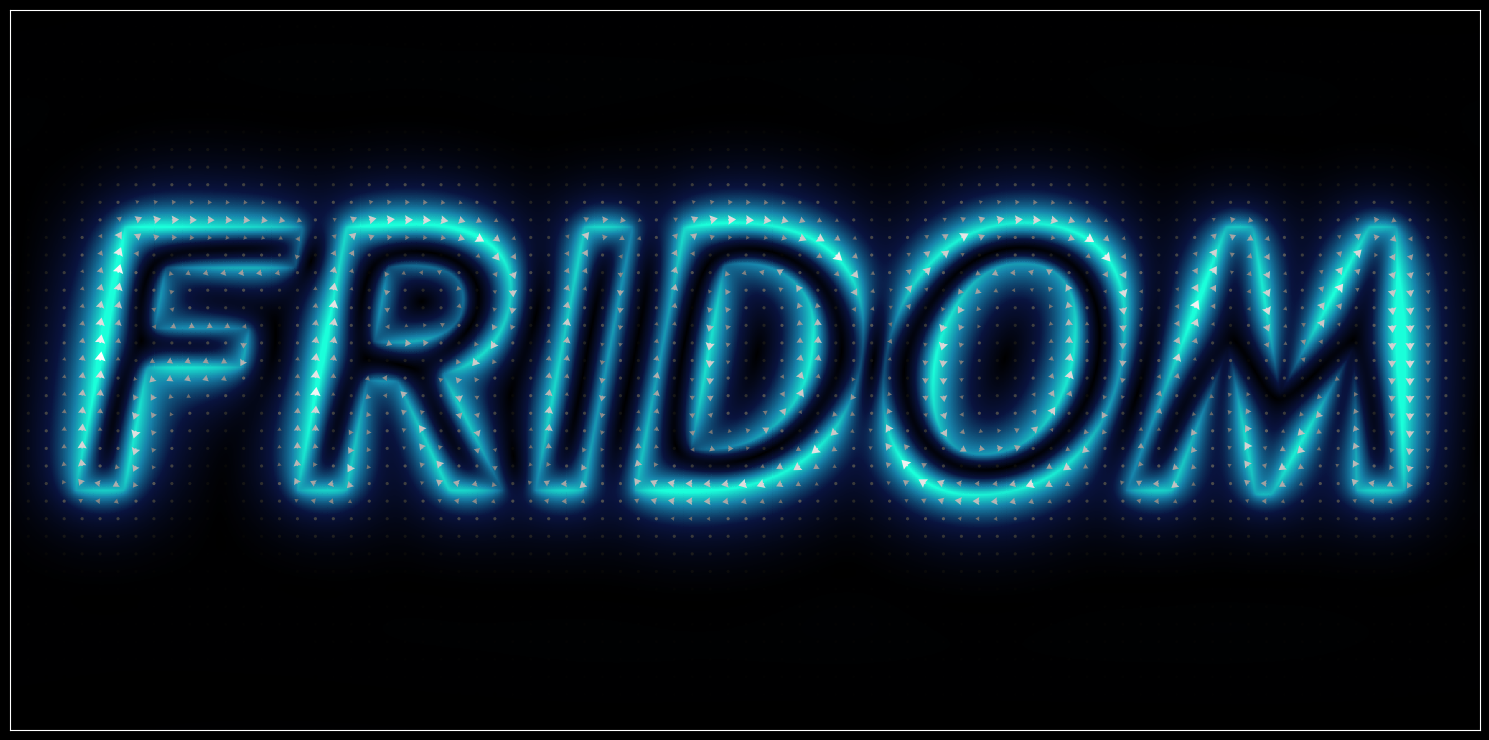

In [7]:
fig = plt.figure(figsize=(15, 7.5), tight_layout=True)
FancyPlotter.update_figure(fig, model2.z.cpu(), 0)
fig.savefig('fridom-title.png', dpi=150)